# Classifying Patient Abilify Ratings from WebMD

## Setup

In [1]:
# imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# download WordNet model for lemmatization

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [4]:
# # load dataset
# # https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

# corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv',
#                      encoding_errors='replace') # use replacement character for characters not in UTF-8
# corpus = corpus[['overall-rating', 'description-text']]

# print(f'Before dropping NAs: {len(corpus)}')
# corpus = corpus.dropna(axis=0)
# corpus = corpus.reset_index(drop=True)
# print(f'After dropping NAs: {len(corpus)}')

# corpus.head(5)

In [5]:
# load dataset from scraping reviews from drugs on WebMD depression drugs list

corpus = pd.read_csv('/kaggle/input/psychiatric-drug-webmd-reviews/psychiatric_drug_webmd_reviews.csv',
                     encoding_errors='replace', # use replacement character for characters not in UTF-8
                     index_col=0)

print(f'Before dropping NAs: {len(corpus)}')
corpus = corpus.dropna(axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping NAs: 28950
After dropping NAs: 22388


,drug_name,date,age,gender,time_on_drug,reviewer_type,condition,rating_overall,rating_effectiveness,rating_ease_of_use,rating_satisfaction,text
0,Abilify Oral,11/12/2023,35-44,Female,less than 1 month,Patient,Additional Medications to Treat Depression,5.0,5,5,5,I started abilify two weeks ago for depression...
1,Abilify Oral,11/6/2023,19-24,Female,6 months to less than 1 year,Patient,Other,3.7,4,5,2,"Great for depression, but it made me have a co..."
2,Abilify Oral,10/2/2023,55-64,Female,1 to 6 months,Patient,Additional Medications to Treat Depression,5.0,5,5,5,I felt a positive affect of level headiness wi...
3,Abilify Oral,9/22/2023,19-24,Male,less than 1 month,Patient,Other,1.3,1,2,1,I was prescribed this in the hospital for bipo...
4,Abilify Oral,9/10/2023,25-34,Male,5 to less than 10 years,Patient,Other,4.3,5,5,3,"gained weight, tiredness, but it works for psy..."


In [6]:
corpus = corpus[['rating_overall', 'text']]

## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


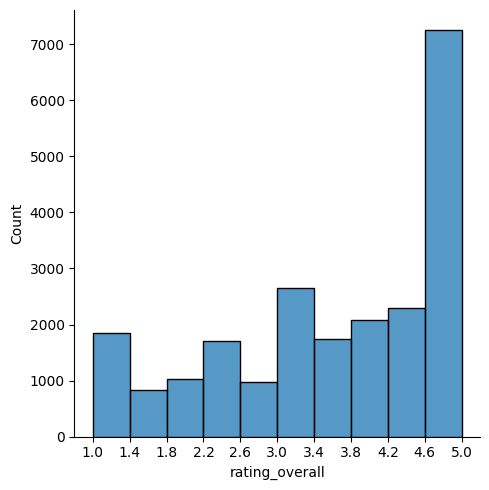

In [7]:
# view distribution of ratings

bins = 10
bin_width = (5-1)/bins
ax = sns.displot(corpus, x='rating_overall', bins=bins)
plt.xticks(np.arange(1, 5+bin_width, bin_width))

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

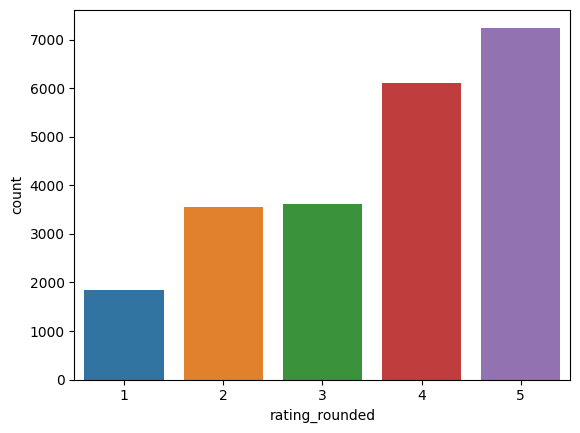

In [8]:
# round ratings and view distribution

corpus['rating_rounded'] = corpus['rating_overall'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [9]:
# TODO: add word cloud
# https://www.datacamp.com/tutorial/wordcloud-python

## Text Preprocessing
https://geeksforgeeks.org/python-word-embedding-using-word2vec/ \
https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [10]:
!pip install pyspellchecker

In [11]:
# correct spellings

from spellchecker import SpellChecker
from tqdm import tqdm

corpus['text_spellchecked'] = corpus['text'].copy()

speller = SpellChecker()
speller.distance = 2
speller.word_frequency.load_words(['Abilify', 'Lexapro', 'SSRI', 'Lamictal', 'Klonopin', 'Latuda', 'escitalopram', 'aripiprazole', 'risperdal'])

for i, sentence in enumerate(tqdm(corpus['text'])):
    words = sentence.split(' ')
    corpus.loc[i, 'text_spellchecked'] = ' '.join([speller.correction(word) if speller.correction(word) is not None else word for word in words])

# print the words unrecognized by the spellchecker

from itertools import chain
words = np.unique(list(chain(*[sentence.split(' ') for sentence in corpus['text_spellchecked']])))
speller.unknown(words)

# save and inspect result of spell checking

corpus.to_csv('psychiatric_drug_reviews_spellchecked.csv')
corpus.head(10)

In [12]:
# # load already spellchecked corpus
# corpus = pd.read_csv('/kaggle/input/abilify-reviews-spellchecked/abilify-reviews-spellchecked.csv')

In [13]:
# apply preprocessing steps - tokenization, lowercase, remove punctuation, lemmatization

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [14]:
corpus['text_preprocessed'] = corpus['text_spellchecked'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i started abilify two week ago for depression ...
1    great for depression but it made me have a com...
2    i felt a positive affect of level headiness wi...
3    i wa prescribed this in the hospital for bipol...
4     gained weight tiredness but it work for psycosis
Name: text_preprocessed, dtype: object

In [15]:
# generate sequences (encode tokens using numeric values) that are padded to the same length
# make equal length sequences in order to use as neural network input

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [16]:
words_sentences = [x.split() for x in sentences]

## Set Up Evaluation Metrics
**balanced accuracy**: average of recall obtained for each class

In [17]:
# compute accuracy and balanced accuracy and plot confusion matrix

from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
                            ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}')


    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Bag of Words and Naive Bayes
Adapted from Natural Language Processing in Action book[](http://)

In [18]:
# produce BOW

from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,started,abilify,two,week,ago,for,depression,and,aggressive,...,whwere,unfortunalty,theinobenzodiazapam,zomby,morked,heinous,shiny-skinned,un-well,enirely,zyprexa.read
0,3,1,1,1,1,1,3,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,1,1,0,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# train-test split

from sklearn.model_selection import train_test_split

y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

accuracy: 0.8696
balanced accuracy: 0.6875


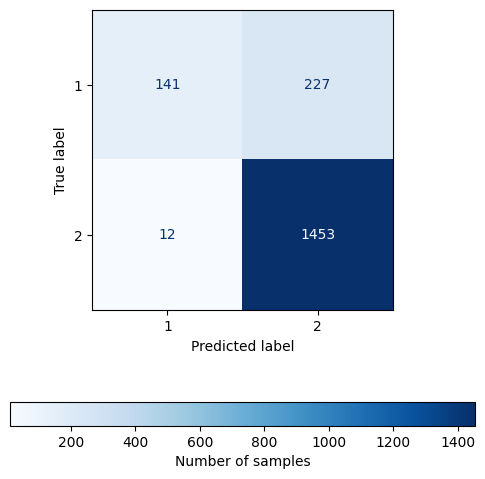

In [20]:
# fit naive Bayes, predict, and evaluate performance

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

evaluation(y_test_subset, y_pred)

In [21]:
# inspect some misclassified samples

one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
# for row in one_star_misclassified.iterrows():
#     print(one_star_misclassified.columns[row[1] != 0])

Index(['i', 'for', 'and', 'it', 'the', 'of', 'is', 'to', 'my', 'day', 'help',
       'after', 'on', 'but', 'a', 'month', 'affect', 'wa', 'prescribed',
       'this', 'anxiety', 'had', 'not', 'bad', 'medication', 'dose', 'no',
       'side', 'one', 'put', 'taking', 'better', 'still', 'case', 'gotten',
       'listed', '5mg', 'doctor', 'eye', 'yes', 'cut', 'dry', 'restasis'],
      dtype='object')
Index(['i', 'and', 'it', 'the', 'of', 'to', 'after', 'a', 'took', 'so', 'this',
       'could', 'work', 'would', 'not', 'bad', 'medication', 'side', 'effect',
       'go', 'taking', 'muscle', 'were', '1/2', 'experienced', 'once',
       'twitch', 'dizziness', 'drowsiness', '50mg', 'suggest', 'tablet'],
      dtype='object')
Index(['i', 'two', 'week', 'and', 'it', 'ha', 'the', 'took', 'med', 'been',
       'all', 'still', 'sick', 'experienced', 'reaction', 'mirtazapine',
       'adverse'],
      dtype='object')
Index(['i', 'started', 'week', 'for', 'it', 'me', 'the', 'of', 'to', 'my',
       'da

## TF-IDF and Latent Semantic Analysis (LSA)
Adapted from Natural Language Processing in Action book[](http://)

In [22]:
# produce TF-IDF matrix

from sklearn.feature_extraction.text import TfidfVectorizer

extreme_bool = (y == 0) | (y == 4)

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(sentences[extreme_bool]).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix = (tfidf_matrix.T / np.linalg.norm(tfidf_matrix, axis=1)).T  # normalize with L2 norm (vector length)
tfidf_matrix[:5]

array([[-6.87683681e-04, -1.43406842e-04, -2.20968361e-05, ...,
        -4.68504156e-05, -1.84873184e-03, -6.97212044e-05],
       [-6.47526880e-04, -1.35032701e-04, -2.08065070e-05, ...,
        -4.41146188e-05, -1.74077646e-03, -6.56498841e-05],
       [-6.75130496e-04, -1.40789050e-04, -2.16934738e-05, ...,
        -4.59951941e-05, -1.81498453e-03, -6.84484925e-05],
       [-6.48655591e-04, -1.35268078e-04, -2.08427750e-05, ...,
        -4.41915155e-05, -1.74381082e-03, -6.57643191e-05],
       [-6.53591320e-04, -1.36297356e-04, -2.10013712e-05, ...,
        -4.45277762e-05, -1.75707977e-03, -6.62647308e-05]])

In [23]:
# perform truncated SVD

from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

<Axes: >

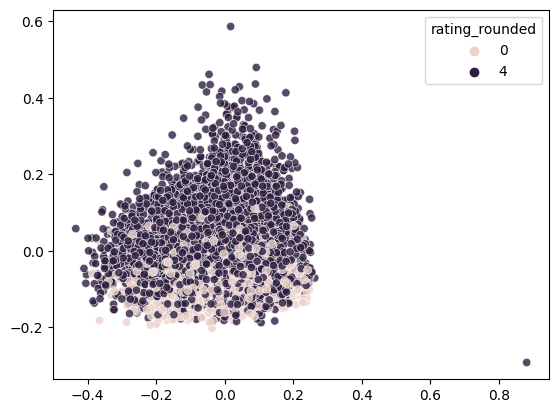

In [24]:
# plot first 2 PCs and color by 1 vs 5 star reviews

x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y[extreme_bool], alpha=0.8)

accuracy: 0.8484
balanced accuracy: 0.6761


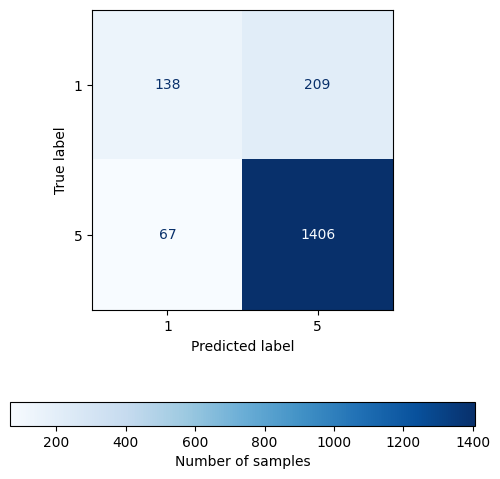

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(svd_topic_vectors, y[extreme_bool], test_size=0.2, random_state=0)
model = LinearDiscriminantAnalysis(n_components=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

## Word2Vec and Convolutional Neural Network (CNN)
Adapted from Natural Language Processing in Action book[](http://)

In [26]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [27]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_values = [w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])

In [28]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', ..., 'zomby', 'morked', 'enirely'],
      dtype='<U63')

In [29]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [30]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [31]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [32]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [33]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
103/103 [==============================] - 12s 10ms/step - loss: 0.5586 - accuracy: 0.6973 - val_loss: 0.6485 - val_accuracy: 0.6369
Epoch 2/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3854 - accuracy: 0.8252 - val_loss: 0.3423 - val_accuracy: 0.8583
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3079 - accuracy: 0.8625 - val_loss: 0.2584 - val_accuracy: 0.8982
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2550 - accuracy: 0.8880 - val_loss: 0.2583 - val_accuracy: 0.8790
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1969 - accuracy: 0.9140 - val_loss: 0.2405 - val_accuracy: 0.8900
Epoch 6/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1680 - accuracy: 0.9269 - val_loss: 0.2336 - val_accuracy: 0.8955
Epoch 7/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9472 - val_loss: 0.3415 - val_accuracy: 0.8693
Epoc

accuracy: 0.9111
balanced accuracy: 0.8457


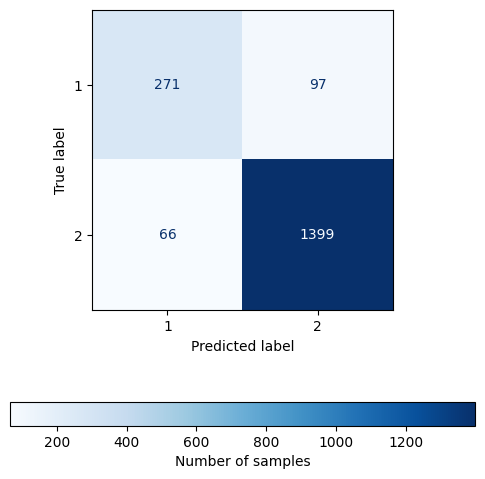

In [34]:
evaluation(y_test_subset, y_pred_label)

## GloVe and CNN

In [35]:
# from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '/kaggle/input/glove6b/glove.6B.300d.txt'
# w2v_output_file = glove_file + '.word2vec'
# glove2word2vec(glove_file, w2v_output_file)

glove_model = gensim.models.KeyedVectors.load_word2vec_format(
                glove_file,
                binary=False,
                no_header=True)

In [36]:
embedding_values = [glove_model[word] if word in glove_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])
                             
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [37]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [38]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
103/103 [==============================] - 3s 9ms/step - loss: 0.6292 - accuracy: 0.6400 - val_loss: 0.6796 - val_accuracy: 0.6025
Epoch 2/50
103/103 [==============================] - 1s 5ms/step - loss: 0.4701 - accuracy: 0.7764 - val_loss: 0.5498 - val_accuracy: 0.7373
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3674 - accuracy: 0.8356 - val_loss: 0.2918 - val_accuracy: 0.8831
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3078 - accuracy: 0.8602 - val_loss: 0.2820 - val_accuracy: 0.8680
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2607 - accuracy: 0.8888 - val_loss: 0.3008 - val_accuracy: 0.8652
Epoch 6/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2243 - accuracy: 0.9018 - val_loss: 0.2446 - val_accuracy: 0.8900
Epoch 7/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1797 - accuracy: 0.9252 - val_loss: 0.2553 - val_accuracy: 0.8913
Epoch 

accuracy: 0.9034
balanced accuracy: 0.8450


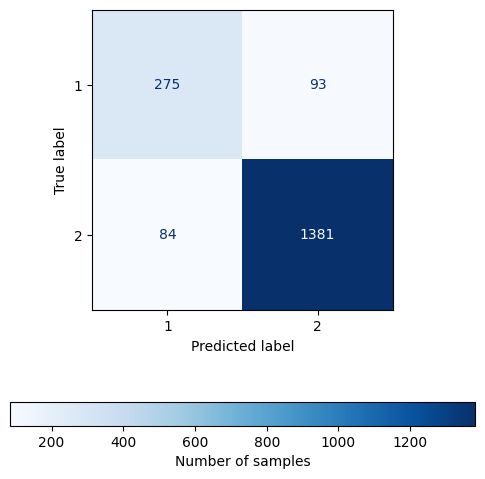

In [39]:
evaluation(y_test_subset, y_pred_label)

## Bidirectional Recurrent Neural Network (RNN)
Adapted from Natural Language Processing in Action book

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)

Epoch 1/20
205/205 [==============================] - 42s 190ms/step - loss: 0.7340 - accuracy: 0.6019 - val_loss: 0.8331 - val_accuracy: 0.4842
Epoch 2/20
205/205 [==============================] - 39s 189ms/step - loss: 0.6269 - accuracy: 0.6690 - val_loss: 0.9669 - val_accuracy: 0.3274
Epoch 3/20
205/205 [==============================] - 39s 189ms/step - loss: 0.5938 - accuracy: 0.6927 - val_loss: 0.4810 - val_accuracy: 0.7827
Epoch 4/20
205/205 [==============================] - 38s 187ms/step - loss: 0.5506 - accuracy: 0.7314 - val_loss: 0.4292 - val_accuracy: 0.8143
Epoch 5/20
205/205 [==============================] - 38s 187ms/step - loss: 0.5367 - accuracy: 0.7518 - val_loss: 0.4640 - val_accuracy: 0.7868
Epoch 6/20
205/205 [==============================] - 38s 186ms/step - loss: 0.4941 - accuracy: 0.7686 - val_loss: 0.4088 - val_accuracy: 0.8129
Epoch 7/20
205/205 [==============================] - 38s 186ms/step - loss: 0.4870 - accuracy: 0.7776 - val_loss: 0.5273 - val_ac

58/58 [==============================] - 2s 23ms/step
accuracy: 0.7049
balanced accuracy: 0.6994


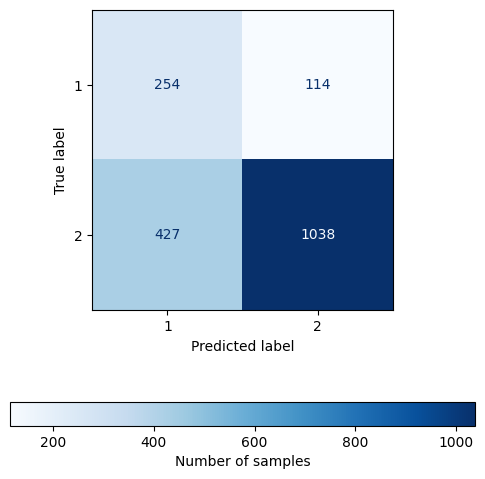

In [41]:
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]
evaluation(y_test_subset, y_pred_label)

## Long Short-Term Memory (LSTM) Network
Adapted from Natural Language Processing in Action book

In [42]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(
            100,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)

Epoch 1/20
205/205 [==============================] - 8s 18ms/step - loss: 0.5843 - accuracy: 0.7065 - val_loss: 0.4823 - val_accuracy: 0.7662
Epoch 2/20
205/205 [==============================] - 3s 14ms/step - loss: 0.4654 - accuracy: 0.7745 - val_loss: 0.3187 - val_accuracy: 0.8790
Epoch 3/20
205/205 [==============================] - 3s 14ms/step - loss: 0.4150 - accuracy: 0.8122 - val_loss: 0.3075 - val_accuracy: 0.8735
Epoch 4/20
205/205 [==============================] - 3s 13ms/step - loss: 0.3655 - accuracy: 0.8403 - val_loss: 0.2750 - val_accuracy: 0.8886
Epoch 5/20
205/205 [==============================] - 3s 13ms/step - loss: 0.3278 - accuracy: 0.8605 - val_loss: 0.3268 - val_accuracy: 0.8569
Epoch 6/20
205/205 [==============================] - 3s 14ms/step - loss: 0.2894 - accuracy: 0.8743 - val_loss: 0.2462 - val_accuracy: 0.9023
Epoch 7/20
205/205 [==============================] - 3s 13ms/step - loss: 0.2549 - accuracy: 0.8932 - val_loss: 0.2838 - val_accuracy: 0.8803

58/58 [==============================] - 1s 5ms/step
accuracy: 0.8865
balanced accuracy: 0.8161


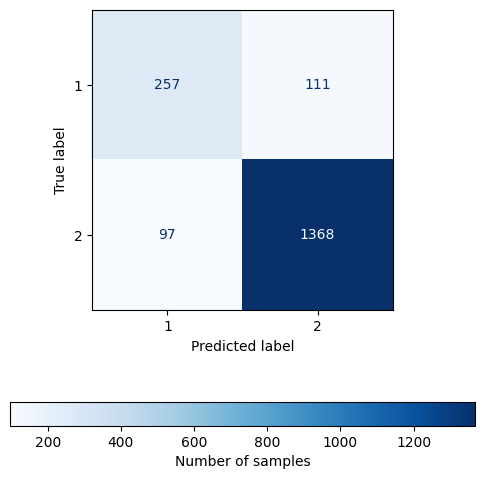

In [43]:
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]
evaluation(y_test_subset, y_pred_label)

In [44]:
# 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [45]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [46]:
model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/100
252/252 [==============================] - 5s 8ms/step - loss: 1.5954 - accuracy: 0.2348 - val_loss: 1.4394 - val_accuracy: 0.3585
Epoch 2/100
252/252 [==============================] - 2s 6ms/step - loss: 1.4661 - accuracy: 0.3344 - val_loss: 1.3887 - val_accuracy: 0.3640
Epoch 3/100
252/252 [==============================] - 2s 7ms/step - loss: 1.3813 - accuracy: 0.3709 - val_loss: 1.3528 - val_accuracy: 0.3735
Epoch 4/100
252/252 [==============================] - 2s 6ms/step - loss: 1.3256 - accuracy: 0.3945 - val_loss: 1.2708 - val_accuracy: 0.4216
Epoch 5/100
252/252 [==============================] - 2s 6ms/step - loss: 1.2677 - accuracy: 0.4186 - val_loss: 1.2864 - val_accuracy: 0.4087
Epoch 6/100
252/252 [==============================] - 2s 7ms/step - loss: 1.2136 - accuracy: 0.4453 - val_loss: 1.3125 - val_accuracy: 0.4115
Epoch 7/100
252/252 [==============================] - 2s 7ms/step - loss: 1.1619 - accuracy: 0.4672 - val_loss: 1.2563 - val_accuracy: 0.4417

accuracy: 0.4080
balanced accuracy: 0.3620


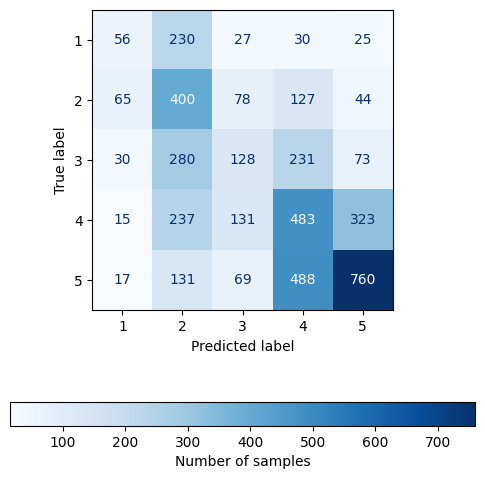

In [47]:
evaluation(y_test, y_pred_label)